In [263]:
import pypsa
import pandas as pd
import numpy as np
import os
import pypsatopo

In [265]:
solver = "cbc"

In [348]:
# Create empty PyPSA network
n = pypsa.Network()

In [349]:
# Set snapshots to the year 2023 and at hourly resolution
snapshots = pd.date_range("01-01-2019", "01-01-2020", freq="h", inclusive="left")
n.set_snapshots(snapshots)

In [352]:
# To calculate annualized capital expenditure
def calculate_annualised_capex(capex: float, interest: float, lifetime: int):
    crf = (
        interest * (1 + interest) ** lifetime / ((1 + interest) ** lifetime - 1)
    )  # Capital recovery factor
    return capex * crf

<Axes: xlabel='snapshot'>

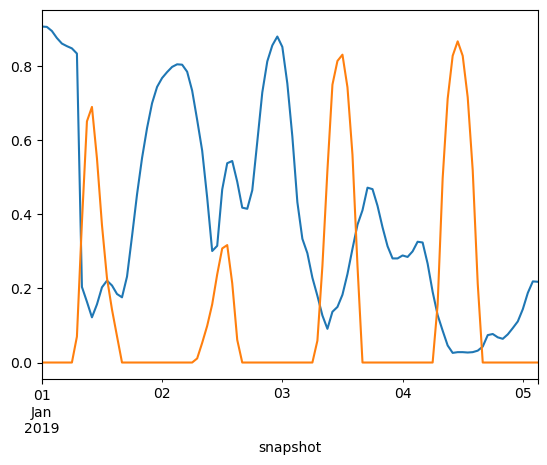

In [354]:
# Import an example of wind daily pattern
wind_pattern = pd.read_csv("/Users/philip/Downloads/2024-10-PyPSA-H2-Training/data/weather data/China_InMo_2019_onshore_wind_41.6401_109.8633_hourly_pattern.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
wind_profile = pd.Series(list(wind_pattern), index=n.snapshots)

# Import an example of solar daily pattern
solar_pattern = pd.read_csv("/Users/philip/Downloads/2024-10-PyPSA-H2-Training/data/weather data/China_InMo_2019_solar_41.6401_109.8633_hourly_pattern.csv")["daily pattern"]
# annual time-series availability of solar (just a simplified example)
solar_profile = pd.Series(list(solar_pattern), index=n.snapshots)

# Import an example of wind daily pattern
load_pattern = pd.read_csv("/Users/philip/Downloads/2024-10-PyPSA-H2-Training/data/weather data/example_industrial_h2_demand_daily_pattern.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
load_profile = pd.Series(list(load_pattern)*365, index=n.snapshots)


# Print first few values to verify
wind_profile.head(100).plot()
solar_profile.head(100).plot()

In [356]:
# create the buses needed for the ammonia system
n.add(class_name="Bus", name="electricity", carrier="electricity", overwrite=True)

n.add(class_name="Bus", name="electricity_storage", carrier="electricity", overwrite=True)

# hydrogen buses
n.add(class_name="Bus", name="hydrogen", carrier="hydrogen", overwrite=True)
n.add(class_name="Bus", name="hydrogen_storage", carrier="hydrogen", overwrite=True)
# ammonia buses
n.add(class_name="Bus", name="ammonia", carrier="ammonia", overwrite=True)
n.add(class_name="Bus", name="ammonia_storage", carrier="ammonia", overwrite=True)

n.buses

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
electricity,1.0,,0.0,0.0,electricity,,1.0,0.0,inf,PQ,,
electricity_storage,1.0,,0.0,0.0,electricity,,1.0,0.0,inf,PQ,,
hydrogen,1.0,,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,
hydrogen_storage,1.0,,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,
ammonia,1.0,,0.0,0.0,ammonia,,1.0,0.0,inf,PQ,,
ammonia_storage,1.0,,0.0,0.0,ammonia,,1.0,0.0,inf,PQ,,


In [358]:
#create the end demand load for ammonia

#n.remove(class_name="Load", name="hydrogen_load")
n.add(class_name="Load", name="ammonia_load", bus="ammonia", p_set=100, overwrite=True) 
#n.add(class_name="Load", name="hydrogen_load", bus="hydrogen", p_set=100, carrier="hydrogen", type="hydrogen_load", overwrite=True)
# or p_set=load_profile
n.loads


,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
ammonia_load,ammonia,,,100.0,0.0,-1.0,True


In [360]:
#exchange rates
eur_to_usd = 1.1
usd_to_cny = 7.0774

# interest rate / discount rate
interest = 0.0563 # according to BOA PTX; original value: 0.05

In [362]:
# create the generators for wind, based on techno-economic parameters
# Onshore Wind's techno-economic parameters are given as:
lifetime = 20
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 4500 * 1000 / usd_to_cny # $/MW
FOM = 2 #% of CAPEX
VOM = 0 # $/MWh variable
efficiency = 1

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="Generator", 
    name="onshore_wind",
    bus="electricity",
    carrier="electricity",
    p_nom_extendable=True,
    p_nom_min=100, # MW
    #p_nom_max=500, # MW
    capital_cost=annualized_capex + FOM/100 * annualized_capex, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=wind_profile, 
    overwrite=True
)

Index(['onshore_wind'], dtype='object', name='Generator')

In [364]:
# create the generator for solar, based on techno-economic parameters
# Solar's techno-economic parameters are given as:
lifetime = 25
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 3940 * 1000 / usd_to_cny # $/MW
FOM = 1 #% of CAPEX
VOM = 0 # $/MWh variable
efficiency = 1

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="Generator", 
    name="solar",
    bus="electricity",
    carrier="electricity",
    p_nom_extendable=True,
    p_nom_min=50,
    #p_nom_max=500, # MW
    capital_cost=annualized_capex + FOM/100 * annualized_capex, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=solar_profile, 
    overwrite=True
)

Index(['solar'], dtype='object', name='Generator')

In [366]:
#create the generator for hybrid supply

#n.add(class_name="Generator", name="hybrid_wind_solar", bus="electricity", carrier="wind", overwrite=True)

n.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
onshore_wind,electricity,PQ,,0.0,0.0,True,100.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
solar,electricity,PQ,,0.0,0.0,True,50.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [368]:
# create hydrogen and ammonia storage tanks

#Techno-economic data for hydrogen storage tank
lifetime = 20
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 59.7 * 1000 # $/MWh (based on H2 compressed storage tank DTU data); original value: 4779.9527
FOM = 0.43 #%/year; unchanged

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
      class_name="Store",
      name="hydrogen_tank",
      type="hydrogen_tank",
      bus="hydrogen_storage",
      carrier="hydrogen",
      capital_cost=annualized_capex + FOM/100 * annualized_capex,
      e_nom_extendable=True,
      e_cyclic=True,
      marginal_cost=1,#$/MWh 
      overwrite=True
)


Index(['hydrogen_tank'], dtype='object')

In [370]:
# Ammonia tank's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 20
interest = 0.0563

CAPEX = 166.8201 * eur_to_usd # $/MWh
FOM = 4.0 # %/year

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)


n.add(
    class_name="Store", 
    name="ammonia_tank",
    type="ammonia_tank",
    bus="ammonia_storage", 
    carrier="ammonia",
    e_nom_extendable=True,
    e_cyclic=True,
    e_initial=0,
    capital_cost= annualized_capex * FOM/100 * annualized_capex,
    marginal_cost=1, 
    overwrite=True
)

n.stores

,bus,type,carrier,e_nom,e_nom_mod,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,...,sign,marginal_cost,marginal_cost_quadratic,marginal_cost_storage,capital_cost,standing_loss,active,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
hydrogen_tank,hydrogen_storage,hydrogen_tank,hydrogen,0.0,0.0,True,0.0,inf,0.0,1.0,...,1.0,1.0,0.0,0.0,5071.388888,0.0,True,0,inf,0.0
ammonia_tank,ammonia_storage,ammonia_tank,ammonia,0.0,0.0,True,0.0,inf,0.0,1.0,...,1.0,1.0,0.0,0.0,9.636523,0.0,True,0,inf,0.0


In [374]:
# Techno-economic parameters of a lithium ion battery storage:

lifetime = 12.5  # years; https://greencubes.com/in-the-news/why-lithium-is-taking-over-stationary-energy-storage/
interest = 0.0563  # unit: -
CAPEX = 80 * 1000  # $/MW; original: 600 # Source: https://www.energy-storage.news/mind-blowing-bids-power-chinas-16gwh-bess-tender-state-owned-firms-market-share/
FOM = 1.5  # $/MW per year (between 1% and 2% of the CAPEX)
VOM = 0  # $/MWh
fuel_cost = 0  # $/MWh_th per unit water consumed
efficiency_store = 0.965  # assuming similar storing and discharging efficiencies #https://blog.discoverbattery.com/understanding-charging
efficiency_dispatch = 0.965  # assuming similar storing and discharging efficiencies

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="StorageUnit",
    name="battery",
    bus="electricity_storage",
    marginal_cost= VOM + fuel_cost,
    capital_cost=annualized_capex + FOM/100 * annualized_capex,
    p_nom_extendable=True,
    efficiency_store=efficiency_store,
    efficiency_dispatch=efficiency_dispatch,
    p_max_pu=1,  # Discharging availability
    p_min_pu=-1,  # Charging availability
#    max_hours=8,  # energy-to-power ratio 
    overwrite=True
)


Index(['battery'], dtype='object')

In [376]:
#create the links for electrolysers, ammonia synthesis, electricity flow and hydrogen flow

n.add(
    class_name="Link", 
    name="electricity_flow",
    bus0="electricity",
    bus1="electricity_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)

n.add(
    class_name="Link", 
    name="hydrogen_flow",
    bus0="hydrogen",
    bus1="hydrogen_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)

n.add(
    class_name="Link", 
    name="ammonia_flow",
    bus0="ammonia",
    bus1="ammonia_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)

n.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,bus2,efficiency2
Link,,,,,,,,,,,,,,,,,,,,,
electricity_flow,electricity,electricity_storage,,,1.0,True,0,inf,0.0,0.0,...,0,1,0,NaN,NaN,1.0,1.0,0.0,,1.0
hydrogen_flow,hydrogen,hydrogen_storage,,,1.0,True,0,inf,0.0,0.0,...,0,1,0,NaN,NaN,1.0,1.0,0.0,,1.0
ammonia_flow,ammonia,ammonia_storage,,,1.0,True,0,inf,0.0,0.0,...,0,1,0,NaN,NaN,1.0,1.0,0.0,,1.0


In [378]:
#create the link for the electrolyser

# Electrolyser's techno-economic parameters are given as:
lifetime = 20
interest = 0.05
#water_cost = 1.8 # EUR/m3_H2O --> this includes the water treatment costs applied to the seawater
#water_demand_ratio= 21 # kgH2O/kgH2 --> how much water is needed to produce 1 kg of hydrogen?

CAPEX = 600.34 # $/MW
FOM = 2 # %/year or CAPEX
VOM = 0 # $/MWh variable
efficiency = 0.59

"""
# Calculate marginal cost for water consumption
# marginal cost [USD/MWh] = 
# water_cost [EUR/m3_H2O] * eur_to_usd [USD/EUR] / 1000 [kgH2O/m3_H2O] * water_demand_ratio [kgH2O/kgH2] / (33.33/1000 [MWh/kgH2])
water_cost = ((water_cost * eur_to_usd / 1000) * water_demand_ratio) / (33.33 / 1000) # 1 kgH2 = 33.33 kWh = 0.03333 MWh

# Add a compressor to pressurize hydrogen produced by the electrolyser and feed it to the hydrogen storage
# 1. Calculate the specific electricity consumption for compressor in kWh_el/kWh_H2. Assumption: 0.6 [kWh_el/kgH2]
# 2. Calculate the specific energy consumption for the electrolyser in kWh_el/kWh_H2. This corresponds to the reciprocal of the electrolyser's efficiency.
# 3. The sum of the two specific energy consumptions represents the total specific energy consumption for the electrolyser including compressor.
# 4. Calculate the new efficiency of the electrolyser which is the reciprocal of the total specific energy consumption.
specific_consumption_compressor = 0.6 / 33.33  # 0.6 [kWh_el/kgH2] / 33.33 [kWh_H2/kgH2] --> kWh_el/kWh_H2
specific_consumption_electrolyser = 1 / efficiency # unit: kWh_el/kWh_H2
new_efficiency = 1 / (specific_consumption_compressor + specific_consumption_electrolyser)

# Compressor's techno-economic parameters are given as:
lifetime_com = 25
CAPEX_COM = 1720 * eur_to_usd # $/MW
FOM_COM = 34 * eur_to_usd  # $/MW fixed
VOM_COM = 0 # $/MWh variable
"""
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)
#annualized_capex_com = calculate_annualised_capex(CAPEX_COM, interest, lifetime_com)

n.add(
    class_name="Link",
    name="electrolyser",
    bus0="electricity",
    bus1="hydrogen",
    p_nom_extendable=True,
    p_nom_min=20,
    capital_cost=annualized_capex + FOM/100 * annualized_capex, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    overwrite=True
)

Index(['electrolyser'], dtype='object')

In [380]:
#create the link for the Haber-Bosch's ammonia synthesis (UPDATE)

# Haber-Bosch's techno-economic parameters are given as:

lifetime = 20 # original value: 30
interest = 0.0563 # according to BOA PTX; original value: 0.05 

CAPEX = 718.9 * 1000 # $/MW; original value: 1622.5424
FOM = 2.0 # %/year 
VOM = 0.0109  # $/MWh_NH3 (nitrogen cost); original value: 0.0225 * eur_to_usd
electricity_input = 0.142 #MWh_el/MWh_NH3; original value: 0.2473
hydrogen_input = 1.21951 #MWh_H2/MWh_NH3; original value: 1.1484

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)


n.add(
    class_name = "Link",
    name = "haber_bosch",
    bus0="electricity",
    bus1="ammonia",
    bus2="hydrogen",
    p_nom_extendable=True,
    carrier="Haber-Bosch",
    efficiency=1 / electricity_input,
    efficiency2=-hydrogen_input / electricity_input,
    capital_cost=(annualized_capex + FOM/100 * annualized_capex) / electricity_input,
    marginal_cost=VOM / electricity_input,
    lifetime=lifetime,
    overwrite=True
)

Index(['haber_bosch'], dtype='object')

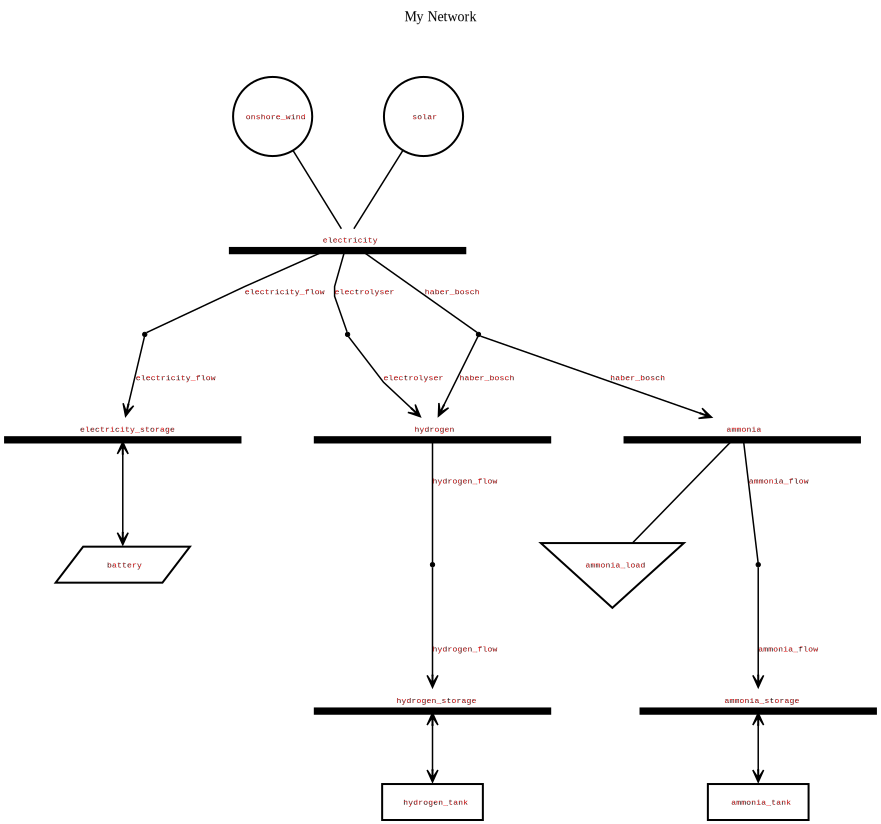

0

In [382]:
pypsatopo.generate(n)

In [384]:
# Solve network using cbc solver
n.optimize(pyomo=False, solver_name=solver)

Index(['onshore_wind', 'solar'], dtype='object', name='Generator')
Index(['hydrogen_tank', 'ammonia_tank'], dtype='object', name='Store')
Index(['electricity_flow', 'hydrogen_flow', 'ammonia_flow', 'electrolyser',
       'haber_bosch'],
      dtype='object', name='Link')
Index(['electricity', 'electricity_storage', 'hydrogen', 'hydrogen_storage',
       'ammonia', 'ammonia_storage'],
      dtype='object', name='Bus')
Index(['onshore_wind', 'solar'], dtype='object', name='Generator')
Index(['hydrogen_tank', 'ammonia_tank'], dtype='object', name='Store')
Index(['electricity_flow', 'hydrogen_flow', 'ammonia_flow', 'electrolyser',
       'haber_bosch'],
      dtype='object', name='Link')
Index(['electricity', 'electricity_storage', 'hydrogen', 'hydrogen_storage',
       'ammonia', 'ammonia_storage'],
      dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous varia

('ok', 'optimal')

In [385]:
n.stores_t.p

Store,hydrogen_tank,ammonia_tank
snapshot,,
2019-01-01 00:00:00,-1.471730,-55.389873
2019-01-01 01:00:00,-1.246824,-55.389873
2019-01-01 02:00:00,0.000000,-54.448300
2019-01-01 03:00:00,0.000000,-51.169509
2019-01-01 04:00:00,0.000000,-48.580990
...,...,...
2019-12-31 19:00:00,0.000000,-55.311140
2019-12-31 20:00:00,-3.046073,-55.389873
2019-12-31 21:00:00,-3.945697,-55.389873


In [386]:
pd.concat([n.stores_t.e,n.stores_t.p],axis=1).head()


Store,hydrogen_tank,ammonia_tank,hydrogen_tank,ammonia_tank
snapshot,,,,
2019-01-01 00:00:00,6.466545,24049.859,-1.471730,-55.389873
2019-01-01 01:00:00,7.713370,24105.249,-1.246824,-55.389873
2019-01-01 02:00:00,7.713370,24159.698,0.000000,-54.448300
2019-01-01 03:00:00,7.713370,24210.867,0.000000,-51.169509
2019-01-01 04:00:00,7.713370,24259.448,0.000000,-48.580990


In [387]:
n.generators.p_nom_opt

Generator
onshore_wind    381.19671
solar            50.00000
Name: p_nom_opt, dtype: float64

<Axes: xlabel='snapshot'>

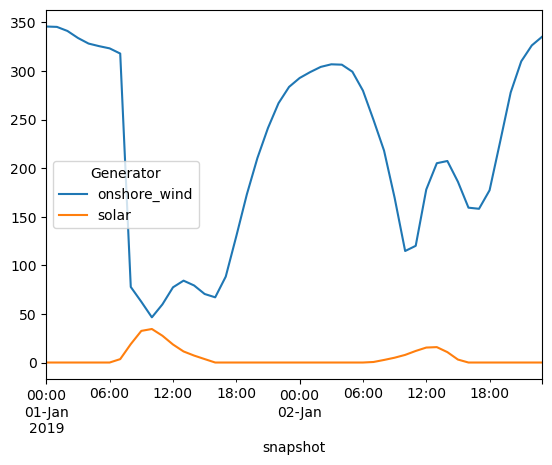

In [388]:
# Inspect the interaction of different power plants to supply loads
n.generators_t.p[:24*2].plot()

<Axes: xlabel='snapshot'>

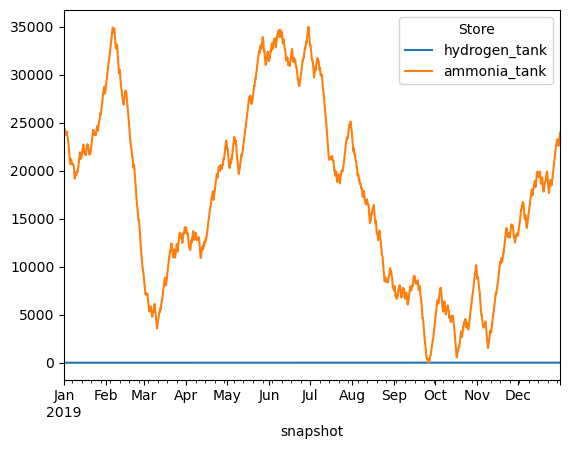

In [389]:
# Inspect the change of energy capacity [MWh] in hydrogen_tank store to supply loads
n.stores_t.e[:24*365].plot()

<Axes: xlabel='snapshot'>

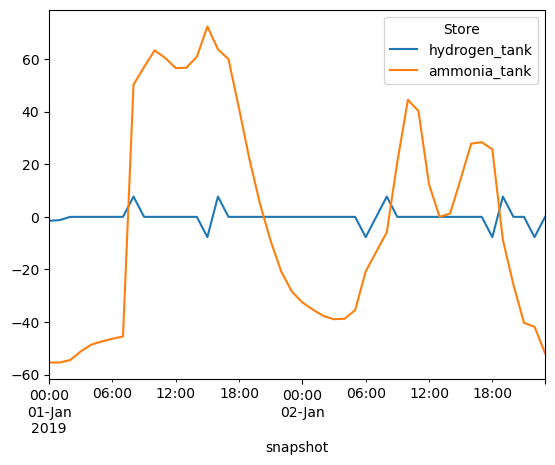

In [390]:
# Inspect the change of power [MW] in hydrogen_tank store to supply loads
n.stores_t.p[:24*2].plot()

<Axes: xlabel='snapshot'>

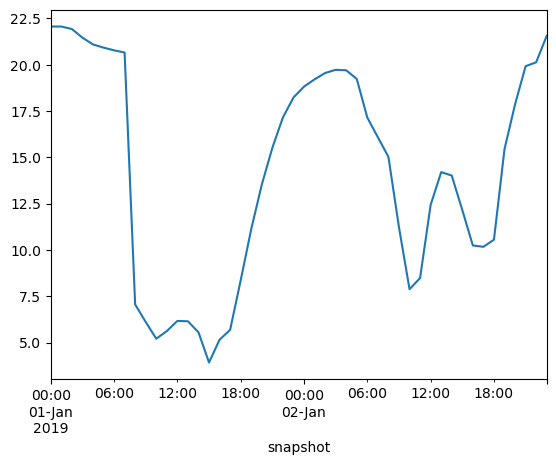

In [391]:
# Inspect the electrolysis input power
#n.links_t.p0["electrolyser"][:24*2].plot()

# Inspect the Haber Bosch input power
n.links_t.p0["haber_bosch"][:24*2].plot()

<Axes: xlabel='snapshot'>

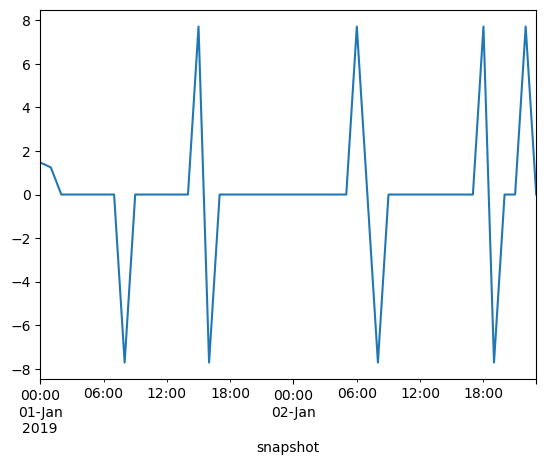

In [392]:
# Inspect the charging flow
n.links_t.p0["hydrogen_flow"][:24*2].plot()

<Axes: xlabel='snapshot'>

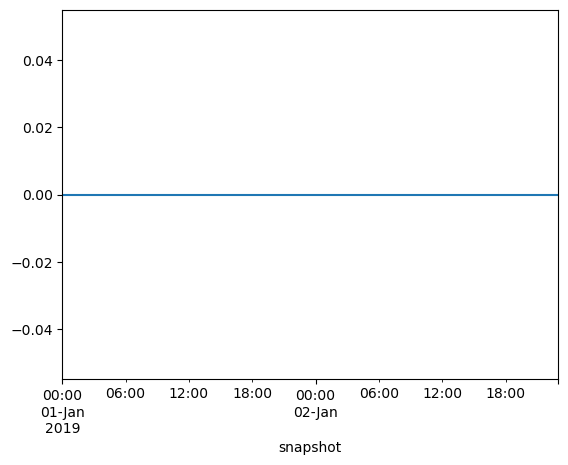

In [393]:
# Inspect the charging flow
n.storage_units_t.p["battery"][:24*2].plot()

<Axes: xlabel='snapshot'>

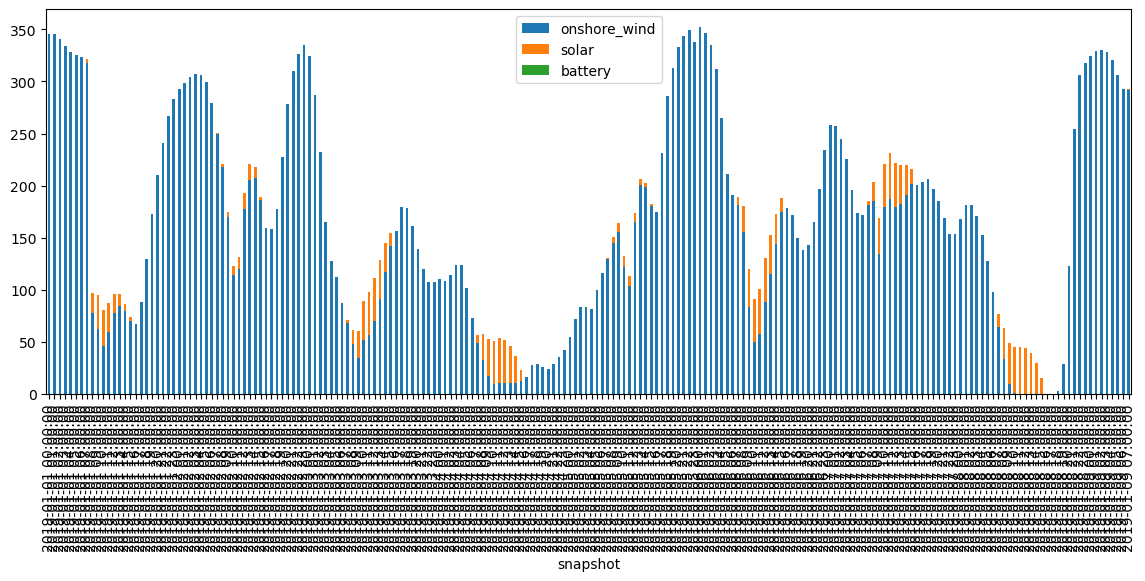

In [394]:
# Inspect storage interaction with other powerplants to supply loads
load = n.loads_t.p
pow_gen = n.generators_t.p
storage = n.storage_units_t.p
result = pd.concat([pow_gen, storage, load], axis=1)

plot = result.loc[
    :, ~result.columns.isin(["ammonia_load"])
]  # drop load and nuclear columns
plot.iloc[:200, :].plot(kind="bar", stacked=True, figsize=(14, 5))

In [395]:
n.statistics()

Optimal Capacity  Installed Capacity        Supply  \
Generator electricity         431.19671                 0.0  1.935054e+06   
Link      Haber-Bosch          22.06536                 0.0  8.760000e+05   
          ammonia             100.00000                 0.0  3.910073e+05   
          electricity         331.11852                 0.0  1.068291e+06   
          hydrogen              7.71337                 0.0  2.376921e+04   
Load      -                     0.00000                 0.0  0.000000e+00   
Store     ammonia           35015.47700                 0.0  1.955036e+05   
          hydrogen              7.71337                 0.0  1.188461e+04   

                         Withdrawal  Energy Balance  Transmission  \
Generator electricity  0.000000e+00    1.935054e+06       0.00000   
Link      Haber-Bosch  1.192683e+06   -3.166828e+05       0.00000   
          ammonia      3.910073e+05    0.000000e+00       0.00033   
          electricity  1.810662e+06   -7.423715e+05       0.00000   
          hydrogen     2.376921e+04    0.000000e+00       0.00000   
Load      -            8.760000e+05   -8.760000e+05       0.00000   
Store     ammonia      1.955036e+05   -3.300000e-04       0.00000   
          hydrogen     1.188461e+04    0.000000e+00       0.00000   

                       Capacity Factor  Curtailment  Capital Expenditure  \
Generator electricity         0.512287  38875.52025         2.303362e+07   
Link      Haber-Bosch         0.643543      0.00000         9.637857e+06   
          ammonia             0.446355      0.00000         0.000000e+00   
          electricity         0.624238      0.00000         1.626994e+04   
          hydrogen            0.351776      0.00000         0.000000e+00   
Load      -                        NaN      0.00000         0.000000e+00   
Store     ammonia             0.495951      0.00000         3.374274e+05   
          hydrogen            0.401599      0.00000         3.911750e+04   

                       Operational Expenditure       Revenue  Market Value  
Generator electricity                  0.00000  2.209047e+07     11.415944  
Link      Haber-Bosch               9548.40001  9.647406e+06     11.013020  
          ammonia                      0.00033  3.300000e-04           NaN  
          electricity                  0.00000  1.627045e+04      0.015230  
          hydrogen                     0.00000  0.000000e+00           NaN  
Load      -                            0.00000 -3.213069e+07           NaN  
Store     ammonia                     -0.00033  3.374274e+05      1.725939  
          hydrogen                     0.00000  3.911750e+04      3.291445

In [300]:
# Exporting Ammonia network
n.export_to_netcdf("/Users/philip/Downloads/2024-10-PyPSA-H2-Training/results/ammonia1-1.nc")

INFO:pypsa.io:Exported network 'ammonia1-1.nc' contains: generators, stores, buses, links, loads, storage_units


<xarray.Dataset> Size: 2MB
Dimensions:                            (snapshots: 8760, investment_periods: 0,
                                        generators_i: 2,
                                        generators_t_p_max_pu_i: 2,
                                        generators_t_p_i: 2, stores_i: 2,
                                        stores_t_p_i: 2, stores_t_e_i: 2,
                                        buses_i: 6, buses_t_p_i: 3,
                                        buses_t_marginal_price_i: 6,
                                        links_i: 5, links_t_p0_i: 4,
                                        links_t_p1_i: 4, links_t_p2_i: 1,
                                        loads_i: 1, loads_t_p_i: 1,
                                        storage_units_i: 1,
                                        storage_units_t_state_of_charge_i: 1)
Coordinates: (12/19)
  * snapshots                          (snapshots) int64 70kB 0 1 ... 8758 8759
  * investment_periods                 (investment_periods) int64 0B 
  * generators_i                       (generators_i) object 16B 'onshore_win...
  * generators_t_p_max_pu_i            (generators_t_p_max_pu_i) object 16B '...
  * generators_t_p_i                   (generators_t_p_i) object 16B 'onshore...
  * stores_i                           (stores_i) object 16B 'hydrogen_tank' ...
    ...                                 ...
  * links_t_p1_i                       (links_t_p1_i) object 32B 'hydrogen_fl...
  * links_t_p2_i                       (links_t_p2_i) object 8B 'haber_bosch'
  * loads_i                            (loads_i) object 8B 'ammonia_load'
  * loads_t_p_i                        (loads_t_p_i) object 8B 'ammonia_load'
  * storage_units_i                    (storage_units_i) object 8B 'battery'
  * storage_units_t_state_of_charge_i  (storage_units_t_state_of_charge_i) object 8B ...
Data variables: (12/55)
    snapshots_snapshot                 (snapshots) datetime64[ns] 70kB 2019-0...
    snapshots_objective                (snapshots) float64 70kB 1.0 1.0 ... 1.0
    snapshots_stores                   (snapshots) float64 70kB 1.0 1.0 ... 1.0
    snapshots_generators               (snapshots) float64 70kB 1.0 1.0 ... 1.0
    investment_periods_objective       (investment_periods) object 0B 
    investment_periods_years           (investment_periods) object 0B 
    ...                                 ...
    storage_units_marginal_cost        (storage_units_i) float64 8B 3.9
    storage_units_capital_cost         (storage_units_i) float64 8B 4.187e+04
    storage_units_max_hours            (storage_units_i) float64 8B 8.0
    storage_units_efficiency_store     (storage_units_i) float64 8B 0.8
    storage_units_efficiency_dispatch  (storage_units_i) float64 8B 0.8
    storage_units_t_state_of_charge    (snapshots, storage_units_t_state_of_charge_i) float64 70kB ...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           33073840.2146927
    network_objective_constant:  0.0
    network_pypsa_version:       0.32.1
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}

In [302]:
"""
# notes
1. update numbers
1.1. update solar #check
1.2. update on_wind #check
1.3. update electrolyser #check (not sure if satisfactory, ramp up?)
1.4. update haber_bosch #check (not sure if satisfactory, ramp up?)
1.5. update hydrogen storage #check
1.6. update ammonia tank ? 
1.7. update battery storage #check (better data available?) 

2. create new wind and solar profiles for China #check
2.1 ninja for wind
2.2 solar atlas for solar?

# questions: 
1. Should there be a curtailment option for solar and wind, or an option to sell excess power to the power market? 
1.1 I am raising this question, as the electrolysis is primarily only running when solar energy is available, instead of more constantly, which seams the intuitive way, given that RES is so cheap?
2. both electrolyser and haber-bosch currently behave according to the intermittance of wind (and solar but less so) 
3. The battery seems to not connect, something seems wrong here. I do wonder if the unit for the capex shouldnt be MWh and not MW? 
4. How do I now determine the LCOA of the whole model? I haven't quite understood how that works.
"""

'\n# notes\n1. update numbers\n1.1. update solar #check\n1.2. update on_wind #check\n1.3. update electrolyser #check (not sure if satisfactory, ramp up?)\n1.4. update haber_bosch #check (not sure if satisfactory, ramp up?)\n1.5. update hydrogen storage #check\n1.6. update ammonia tank ? \n1.7. update battery storage ? \n\n2. create new wind and solar profiles for China #check\n2.1 ninja for wind\n2.2 solar atlas for solar?\n\n# questions: \n1. curtailment option for solar and wind? option to sell it to the power market? \n1.1 I am raising this question, as the electrolysis is primarily only running when solar energy is available, instead of more constantly, which seams the intuitive way, given that RES is so cheap?\n'

In [303]:
#References: 
#1- Agora Energiewende (2024). PyPSA Agora H2 Training. https://github.com/agoenergy/pypsa-agora-h2-training/tree/main
#2- Agora Energy Transition China (2025). China green LCO-X dataset. 
#3- wind and solar profiles: https://www.renewables.ninja/